# ST445 Project: Investigation into the relationship between TripAdvisor and Health & Safety ratings for Cambridge restaurants. 

This study will focus on two data sources related to Cambridge-based restaurants. The first is the Food Standards Agency's (FSA) ratings for food serving establishments in Cambridge. The FSA publish their health and safety ratings for every single establishment they have inspected in country. Publicly available online as downloadable XML files, the data details the FSA's ratings and includes some useful features like establishment type and geographical co-ordinates. The second is a scraping of data from TripAdvisor's listings for restaurants in Cambridge; we will mostly look at just business type and rating. TripAdvisor's workings are not particularly transparent but we can extract the rating they give each listed establishment (to the nearest 0.5).

Once these sources have been acquired and cleaned there are some interesting questions we might be able to answer:
- Is there a relationship between the TripAdvisor and FSA ratings for a given establishment?
- Are the distributions of ratings constant across different types of establishment?

Alongside the statistical analyses, this project will provide an interactive mapping of the establishments and their ratings that could prove useful to potential visitors to or inhabitants of Cambridge! Consumers will be able to see the locations of restaurants and both their TripAdvisor and FSA ratings.

In [1]:
import folium
import json
import Levenshtein
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
import sqlite3 as sq3
import string
import time
import warnings
import xml.etree.ElementTree as ET
import xml.dom.minidom

from matplotlib.ticker import MaxNLocator
from bs4 import BeautifulSoup
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

## Data Downloading and Scraping

Let's start by reading in the FSA health and safety ratings for Cambridge restaurants. The data is stored in downloadable XML files on the FSA website, each file representing a different geographical area; we will read it into a pandas dataframe before writing to an SQL database. The XML file contains entries for every single establishment licensed to serve food in Cambridge, for the purposes of this study we are only interested in restaurants, cafes and similar types (i.e. public venues and not private canteens for example). 

In [2]:
url = "https://ratings.food.gov.uk/OpenDataFiles/FHRS027en-GB.xml"

res = requests.get(url)

# printing the XML tree helps to visually parse the file and find the relevant information
print(xml.dom.minidom.parseString(res.content).toprettyxml())

root = ET.fromstring(res.content)

# loop through the establishments and store the entries in a list
rows = []
for establishment in root[1]:
    row = {}
    for attr in establishment:
        if len(attr) != 0:
            for i in attr:
                row[i.tag] = i.text
        else:
            row[attr.tag] = attr.text
    
    rows.append(row)  

# create the dataframe
df = pd.DataFrame(rows)

# We are only interested in select business types, let's print the unique values and then filter out the
# unwanted ones.
print(set(df["BusinessType"]))
df = df[df["BusinessTypeID"].isin(["1", "7844", "7846"])]

# Create a new column that holds the name lowercased, depunctuated and with some prefix & suffix words stripped 
# in order to match with TripAdvisor names. The purpose of this will become more apparent later on. 
df["NameAlphaNum"] = [name.translate(str.maketrans('', '', string.punctuation)).lower().replace('the ', '').replace(' restaurant', '')
                      for name in df["BusinessName"].values]

# Create the SQL database to write our tables to. By creating a temporary table first we can choose the 
# variables we want our final table to store. 
con = sq3.connect("RestaurantsCambridge.db")
try:
    df.to_sql("temp", con)
    with con:
        con.execute("""CREATE TABLE fsa (Name VARCHAR,         
                                         NameAlphaNum VARCHAR, 
                                         Address1 VARCHAR,     
                                         Address2 VARCHAR,     
                                         Latitude FLOAT,       
                                         Longitude FLOAT,      
                                         RatingDate DATE,      
                                         Rating INT,            
                                         ConfInMgmt INT,       
                                         Hygiene INT,          
                                         Structural INT);""")
        con.execute("""INSERT INTO fsa (Name, NameAlphaNum, Address1, Address2, Latitude, Longitude, RatingDate, 
                                        Rating, ConfInMgmt, Hygiene, Structural)                                   
                       SELECT BusinessName, NameAlphaNum, AddressLine1, AddressLine2, Latitude, Longitude, 
                              RatingDate, RatingValue, ConfidenceInManagement, Hygiene, Structural                              
                       FROM temp;""")
        con.execute("DROP TABLE temp;")
      
# this will throw an error if the table has already been written, if so we need not write it again
except ValueError:
    pass

<?xml version="1.0" ?>
<FHRSEstablishment xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
	<Header>
		<ExtractDate>2020-01-25</ExtractDate>
		<ItemCount>1346</ItemCount>
		<ReturnCode>Success</ReturnCode>
	</Header>
	<EstablishmentCollection>
		<EstablishmentDetail>
			<FHRSID>1094287</FHRSID>
			<LocalAuthorityBusinessID>PI/000096846</LocalAuthorityBusinessID>
			<BusinessName>1 and 1 Rougamo Ltd</BusinessName>
			<BusinessType>Restaurant/Cafe/Canteen</BusinessType>
			<BusinessTypeID>1</BusinessTypeID>
			<AddressLine1>84 Regent Street</AddressLine1>
			<AddressLine2>Cambridge</AddressLine2>
			<AddressLine3>Cambridgeshire</AddressLine3>
			<PostCode>CB2 1DP</PostCode>
			<RatingValue>3</RatingValue>
			<RatingKey>fhrs_3_en-GB</RatingKey>
			<RatingDate>2019-03-19</RatingDate>
			<LocalAuthorityCode>027</LocalAuthorityCode>
			<LocalAuthorityName>Cambridge City</LocalAuthorityName>
			<LocalAuthorityWebSite>http://www.cambridge.gov.uk</LocalAuthorityWebSite>
			<LocalAuthority

Next we will scrape information on every tripadvisor restaurant listing for Cambridge. As before we will write into a pandas dataframe before writing a new table in our existing database. This is made slightly more complicated by tripadvisor's layout: establishments are divided into categories (e.g. restaurant, quick bite, dessert etc.) and they are each displayed seperately. 

PLEASE NOTE: IF THERE IS AN ERROR IT MEANS TRIPADVISOR MAY HAVE CHANGED THEIR WEBSITE - CONTINUE NAVIGATING THE NOTEBOOK A BACKUP COPY SQL DB WILL BE USED INSTEAD!

AlSO RUNNING THIS CELL TAKES <1 MIN (~20 PAGES IN TOTAL)

In [3]:
# each value in page_urls is the first page for the key's listings
page_urls = dict(restaurants="/Restaurants-g186225-Cambridge_Cambridgeshire_England.html",
                 quick_bites="/Restaurants-g186225-zfg16556-Cambridge_Cambridgeshire_England.html",
                 dessert="/Restaurants-g186225-zfg9909-Cambridge_Cambridgeshire_England.html",
                 coffee="/Restaurants-g186225-zfg9900-Cambridge_Cambridgeshire_England.html", 
                 bakeries="/Restaurants-g186225-zfg9901-Cambridge_Cambridgeshire_England.html",
                 bars="/Restaurants-g186225-zfg11776-Cambridge_Cambridgeshire_England.html",
                 market="/Restaurants-g186225-zfg16548-Cambridge_Cambridgeshire_England.html")

base_url = "https://www.tripadvisor.co.uk"

session = requests.Session()

# create a unique identifier for each restaurant that will be useful later on
RestaurantID = 1

df = pd.DataFrame()

# if there are any errors here it means TripAdvisor changed their website
try:
    # loop through the urls defined above and add the results to a pandas dataframe
    for establishment_type, page_url in page_urls.items():

        res = session.get(base_url+page_url)

        page = 1

        while True:

            print("fetching ratings for {} page {}".format(establishment_type, page))

            # find the list of establishments in the request result soup
            soup = BeautifulSoup(res.text, "html.parser")
            eats = soup.find_all(class_="restaurants-list-ListCell__cellContainer--2mpJS")

            for eat in eats:

                # try and find the name for each element in the list, there are sponsored items in the container
                # that have a slightly different format - these are skipped in the except block
                try:
                    name = eat.find(class_="restaurants-list-ListCell__restaurantName--2aSdo").text.split(". ")[1]
                except IndexError:
                    continue

                try:
                    # find the number of ratings for the establishment
                    number = eat.find(class_="restaurants-list-ListCell__userReviewCount--2a61M").text.split(" ")[0]

                    # the rating is hidden inside an image element, we extract it like so 
                    rtext = str(eat.find(class_="restaurants-list-ListCell__bubbleRating--1i1jl"))
                    rating = int(rtext[rtext.index(" bubble_")+8:][:2])/10

                # some listings have no ratings yet so and throw errors
                except AttributeError:
                    number = None
                    rating = None

                # This part is slightly subtle. Some establishments might appear, e.g., in both the restaurant
                # and bakery listings. Before appending to the dataframe let's ensure they are not already present.

                # the first entry will definitely not be present (but does throw an AttributeError) so we skip
                if RestaurantID != 1:

                    # if the name of the establishment is present it might represent a seperate location
                    if df.Name.str.contains(name).any():

                        # if an entry has the same name and number of reviews it is likely to be a duplicate
                        if str(number) in list(df.loc[df.Name==name, 'Number']):
                            continue

                # add the relevant bits of information to a dict and then append to the dataframe
                row = dict(RestaurantID=int(RestaurantID), Name=name, Number=number, Rating=rating, 
                           Type=establishment_type)

                df = df.append(row, ignore_index=True)
                RestaurantID += 1

            # if we have reach the last page (or there are more pages than we anticipated) we break
            if soup.find(class_="nav next disabled") is not None or page > 20:            
                break

            # otherwise we update the page_url with the url given in the next page button
            try:
                page_url = soup.find(class_="nav next rndBtn ui_button primary taLnk").attrs["href"]
            except AttributeError:
                break

            # sleep quickly just to make sure we don't get a timeout or anything
            time.sleep(2)

            res = session.get(base_url+page_url)

            page += 1

        # as above we create a stripped down version of the name variable
        df["NameAlphaNum"] = [name.translate(str.maketrans('', '', string.punctuation)).lower().replace('the ', '').replace(' restaurant', '')
                              for name in df["Name"].values]

    # write to the existing database
    df.to_sql("tripadvisor", con, index=False)
        
except:
    # resort back to the copy
    print("Scraping failed this time - fall back to database copy.")
    con = sq3.connect("RestaurantsCambridgeCopy.db")

fetching ratings for restaurants page 1
fetching ratings for restaurants page 2
fetching ratings for restaurants page 3
fetching ratings for restaurants page 4
fetching ratings for restaurants page 5
fetching ratings for restaurants page 6
fetching ratings for restaurants page 7
fetching ratings for restaurants page 8
fetching ratings for restaurants page 9
fetching ratings for restaurants page 10
fetching ratings for restaurants page 11
fetching ratings for restaurants page 12
fetching ratings for restaurants page 13
fetching ratings for restaurants page 14
fetching ratings for restaurants page 15
Scraping failed this time - fall back to database copy.


## Exploratory Analysis

Let's have a look at the two tables in our database.

In [4]:
print("TripAdvisor")
pd.read_sql_query("""SELECT *  
                     FROM tripadvisor 
                     LIMIT 10;""", con, index_col="RestaurantID")

TripAdvisor


,Name,Number,Rating,Type,NameAlphaNum
RestaurantID,,,,,
1,Restaurant 22,303,5.0,restaurants,restaurant 22
2,Amelie Flam-kuche,191,5.0,restaurants,amelie flamkuche
3,Cafe Blue Sage,114,5.0,restaurants,cafe blue sage
4,Taj Tandoori,815,4.5,restaurants,taj tandoori
5,Africfood,220,5.0,restaurants,africfood
6,Bread & Meat,854,4.5,restaurants,bread meat
7,Tradizioni,481,4.5,restaurants,tradizioni
8,The Corner House,134,4.5,restaurants,corner house
9,Cotto,727,4.5,restaurants,cotto


In [5]:
print("FSA")
pd.read_sql_query("""SELECT * 
                     FROM fsa 
                     LIMIT 10;""", con, index_col="RestaurantID")

FSA


,Name,NameAlphaNum,Address1,Address2,Latitude,Longitude,RatingDate,Rating,ConfInMgmt,Hygiene,Structural
RestaurantID,,,,,,,,,,,
241,1 and 1 Rougamo Ltd,1 and 1 rougamo ltd,84 Regent Street,Cambridge,52.200213,0.126235,2019-03-19,3,10.0,10.0,5.0
149,196,196,Cambridge,Cambridgeshire,52.197345,0.145033,2015-01-22,5,5.0,5.0,0.0
244,2648 Cambridge,2648 cambridge,14A Trinity Street,Cambridge,52.206944,0.117951,2018-11-30,1,20.0,10.0,15.0
569,5 Blends,5 blends,42 Mill Road,Cambridge,52.201248,0.133661,2019-05-03,AwaitingInspection,NaN,NaN,NaN
0,Africfood,africfood,123 Newmarket Road,Cambridge,52.208990,0.140106,2019-06-05,5,5.0,5.0,5.0
91,Agora at The Copper Kettle,agora at copper kettle,3-4 Kings Parade,Cambridge,52.204384,0.117800,2017-12-30,5,0.0,5.0,5.0
65,Al Casbah Restaurant,al casbah,62 Mill Road,Cambridge,52.200419,0.135743,2018-10-23,5,5.0,5.0,5.0
0,Alan Podemsky,alan podemsky,Masonic Lodge,Bateman Street,52.195332,0.125710,2019-02-11,5,5.0,5.0,5.0
0,Alimentum,alimentum,152-154 Hills Road,Cambridge,52.188889,0.135849,2018-09-07,2,10.0,15.0,10.0


It's not immediately obvious what the sub-ratings (ConfInMgmt, Hygiene, Structural) represent and how they are defined, as well as being incomplete in many cases: they're not particularly important to this project so we will proceed without them.

There may be slight differences between the names listed on TripAdvisor and on the FSA website; let's see how many matches we get when we try to join the two tables.

In [6]:
# find the number of matches
print(*con.execute("""SELECT COUNT(*) 
                      FROM tripadvisor  
                      JOIN fsa  
                      WHERE LOWER(fsa.NameAlphaNum) =  
                            LOWER(tripadvisor.NameAlphaNum);""").fetchall()[0],
      " matching pairs out of a potential",
      
      # find the maximum potential matches
      min(*con.execute("SELECT COUNT(*) FROM fsa;").fetchall()[0],
          *con.execute("SELECT COUNT(*) FROM tripadvisor;").fetchall()[0]), ".", sep="")

288 matching pairs out of a potential463.


In [7]:
print(*con.execute("""SELECT COUNT(NameAlphaNum) - COUNT(DISTINCT NameAlphaNum) 
                      FROM tripadvisor""").fetchall()[0],
      "duplicate names in the TripAdvisor table.")

print(*con.execute("""SELECT COUNT(RestaurantID) - COUNT(DISTINCT RestaurantID) 
                      FROM fsa WHERE RestaurantID != 0""").fetchall()[0],
      "duplicate names in the FSA table.")

40 duplicate names in the TripAdvisor table.
1 duplicate names in the FSA table.


There are probably many pairs between the tables that have slight differences in names that have not been joined in the above search. There are also many incorrect pairs resulting from the duplicate names (a company might have several branches in Cambridge) that might get matched erroneously.


To try and further match pairs we will use the Levenshtein distance to measure disimilarity between the names. This distance represents the number of omissions and inversions between two strings; a low number means two strings are similar. We will also remove pairs that could be incorrect. Hypothetically we could try and match duplicate names based on the addresses but this would be quite an involved process (would require many clicks on TripAdvisor).

In [8]:
Levenshtein.distance("hello", "heeo")

2

We will read the names into python lists so we can compute the Levenshtein distances. We create a dictionary with names (as listed on the FSA website) as keys and IDs (as defined in the tripadvisor table) as values. Using this we can identify matching entries between the two tables. 

In [9]:
# store the two groups of names as lists so we can compute the Levenshtein distances between pairs
ta_names = list(con.execute("SELECT NameAlphaNum FROM tripadvisor").fetchall())
fsa_names = list(con.execute("SELECT NameAlphaNum FROM fsa").fetchall())

# flatten the lists 
ta_names = [i[0] for i in ta_names]
fsa_names = [i[0] for i in fsa_names]

# Create a dict to store IDs for entries in the fsa table corresponding to the IDs in the tripadvisor table. As
# dict keys are unique it automatically removes duplicates; we could go a step further and remove all keys for 
# which duplicates exist (not just removing duplicates) but for our purposes this is not necessary!
fsaIDs = dict(zip(fsa_names, [0]*len(fsa_names)))

# in this loop we update the IDs in fsaIDs if there is a unique, clearly matching entry in the tripadvisor table
for ta_name in ta_names:
    
    if ta_names.count(ta_name) > 1:
        continue

    distances = [Levenshtein.distance(ta_name, fsa_name) for fsa_name in fsa_names]

    # if any pair of names is sufficiently close then update the relevant ID
    if any(np.array(distances) < 2):

        # find the corresponding ID
        ID = con.execute("""SELECT RestaurantID  
                            FROM tripadvisor 
                            WHERE NameAlphaNum LIKE ?""", (ta_name,)).fetchall()[0][0]
        
        # update the dictionary
        fsaIDs[fsa_names[np.argmin(distances)]] = ID

print(sum([ID!=0 for ID in fsaIDs.values()]), "out of", len(fsaIDs), "pairs of entries identified between " +
      "the tables")

128 out of 425 pairs of entries identified between the tables


Programmatically we have matched 128 pairs; we will identify the rest by hand. To do this we write our results so far to a JSON file and do some manual updating. We can then read the completed (as far as possible) dict from the manually updated JSON file. 

In [10]:
# once we have written to our JSON file we don't want to overwrite the manually updated changes so we leave 
# this next block commented out

#with open('fsaIDs.json', 'w') as file:
#    json.dump(fsaIDs, file)

with open("fsaIDs.json", "r") as file:
    data = file.read()
    
fsaIDs = json.loads(data)

print(np.count_nonzero(list(fsaIDs.values())), "pairs of IDs identified.")

188 pairs of IDs identified.


Next we will create a new column in the fsa table and update it with the corresponding IDs. We can now use the IDs as a foreign key to join the two tables. Let's see how many results this gives us.

In [11]:
try:
    with con:
        #con.execute("ALTER TABLE fsa ADD RestaurantID INT;")
        for name, ID in fsaIDs.items():
            con.execute("""UPDATE fsa  
                           SET RestaurantID = ?  
                           WHERE NameAlphaNum = ? """, (ID, name))
            
# this will throw an error if the column already exists (which it will for all but the first run)
except sq3.OperationalError:
    pass

print(*con.execute("""SELECT COUNT(*)  
                      FROM tripadvisor  
                      JOIN fsa  
                      WHERE fsa.RestaurantID = tripadvisor.RestaurantID;""").fetchall()[0], "matched pairs.")

189 matched pairs.


Interestingly we have picked up an extra pair... let's see where this came from

In [12]:
print(*con.execute("""SELECT temp1.*
                      FROM fsa AS temp1
                      JOIN (SELECT * 
                            FROM fsa
                            WHERE RestaurantID != 0
                            GROUP BY RestaurantID
                            HAVING COUNT(RestaurantID) > 1) AS temp2
                      ON temp1.RestaurantID = temp2.RestaurantID""").fetchall(), sep="\n")

('Charcoal Grill', 'charcoal grill', '59 Hills Road', 'Cambridge', 52.195413, 0.131098, '2019-02-15', 3, 10, 5, 10, 235)
('Charcoal Grill', 'charcoal grill', '59 Hills Road', 'Cambridge', 52.195413, 0.131098, '', 'AwaitingInspection', None, None, None, 235)


We can see that this an erroneous duplicate. Both rows refer to the exact same establishment and the row with no rating should be removed!

In [13]:
with con:
    con.execute("""DELETE FROM fsa
                   WHERE RestaurantID = 235 AND Rating LIKE 'AwaitingInspection'""")

# Visualisation

Now let's compare the ratings to see if there are any patterns. We will start with some plots before computing some statistics.

Text(0.5, 0.9, 'TripAdvisor and FSA Ratings Counts')

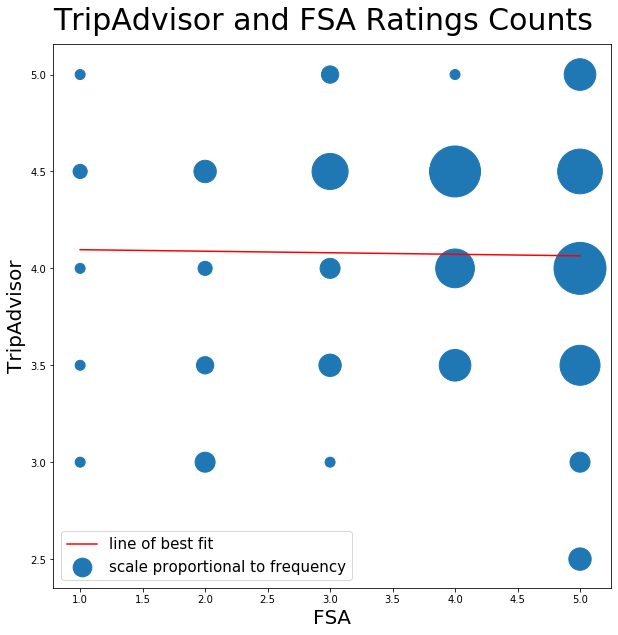

In [14]:
# create a dataframe with the desired information
df = pd.read_sql_query("""SELECT fsa.Name, fsa.Rating, tripadvisor.Rating, fsa.Latitude, fsa.Longitude,   
                                 tripadvisor.Type  
                          FROM tripadvisor 
                          JOIN fsa  
                          WHERE fsa.RestaurantID = tripadvisor.RestaurantID;""", con)

df.columns = ['Name', 'fsaRating', 'taRating', 'Latitude', 'Longitude', 'Type']

# some FSA ratings are 'awaiting inspection' -  we will coerce these to nan and drop these rows
df.fsaRating = pd.to_numeric(df.fsaRating, errors='coerce')
df = df.dropna()

# As the two series are discrete (multiples of 0.5 and multiples of 1) we need a better way of plotting
# than a standard scatter. We will thus groupby the different level pairs and use the point size to represent
# the counts for each pair. 
counts = df.groupby(['fsaRating','taRating']).size().reset_index().rename(columns={0:'count_'})

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

counts.plot.scatter('fsaRating', 'taRating', ax=ax, s=counts.count_*100, label="scale proportional to frequency")

# add a line of best fit
plt.plot(np.unique(df.fsaRating), 
         np.poly1d(np.polyfit(df.fsaRating, df.taRating, 1))(np.unique(df.fsaRating)), 
         color="red", label="line of best fit")

ax.set_xlabel("FSA", fontsize=20)
ax.set_ylabel("TripAdvisor", fontsize=20)

plt.legend(loc=3, fontsize=15, markerscale=0.5)
plt.figtext(.5, .9, "TripAdvisor and FSA Ratings Counts", fontsize=30, ha='center')

Let's have a look at the breakdown of TripAdvisor ratings by restaurant type. We will start with a boxplot. It's worth remembering that some establishments are categorised as more than one type (e.g. could be 'restaurant' and 'bars'); for these cases priority was given to the first occurence (i.e. restaurant > quick_bites > dessert > coffee > bakeries > bars > markets). If we were particularly interested in this breakdown we could adjust this behaviour, however for a quick exploration this will suffice.  

Text(0.5, 0.9, 'TripAdvisor Ratings by Establishment Type')

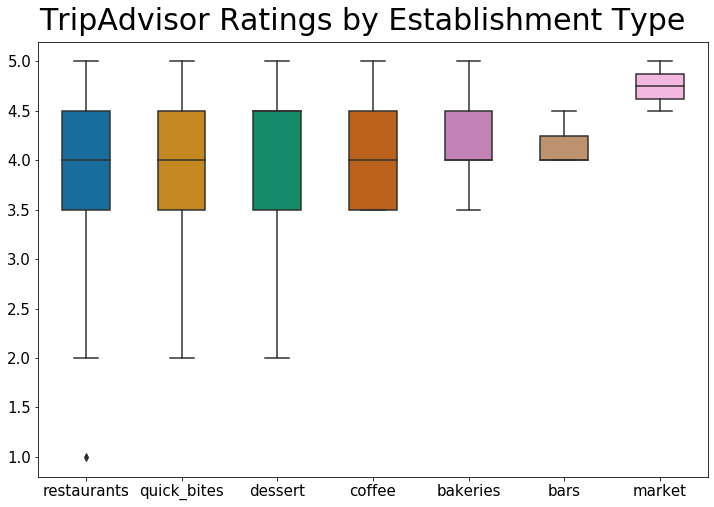

In [15]:
# re-query the db so we get all tripadvisor ratings not just from matched establishments
df2 = pd.read_sql_query("SELECT Name, Rating, Type FROM tripadvisor ", con)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

# seaborn has a nice default boxplot
bplot = sns.boxplot(y="Rating", x="Type", 
                    data=df2, 
                    width=0.5,
                    palette="colorblind").tick_params(labelsize=15)
ax.set_xlabel("")
ax.set_ylabel("")
plt.figtext(.5, .9, "TripAdvisor Ratings by Establishment Type", fontsize=30, ha='center')

It's apparent that here a boxplot might not be the best means of visualisation. Let's try plotting frequency plots separated by business type. This will allow us to better understand the shapes of the empirical distributions and to get a better idea of the comparative sample sizes.

Text(0.99, 0.76, 'Histograms of\n TripAdvisor Ratings\n by Business Type')

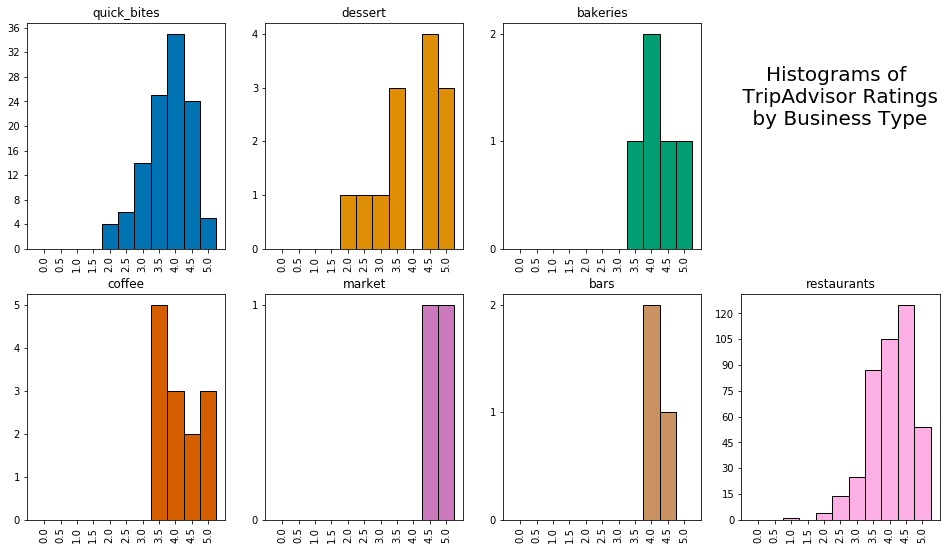

In [16]:
# We want to use the same colour palette as before. This means converting the Seaborn palette to hex so we can
# use it in Matplotlib. We'll make a generator from it.
colours=(colour for colour in sns.color_palette('colorblind').as_hex())

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=[13,5])

# indices to help us navigate subplots
i=0; j=0
x=np.linspace(0, 5, 11)

for type_ in set(df2.Type):
    
    # we want full counts for each increment of 0.5 from 0 to 5, reindexing will add 0s where we need them
    axs[i][j].bar(x, df2[df2.Type==type_].Rating.value_counts().reindex(x, fill_value=0).values,
                  edgecolor='black', width=0.5, color=colours.__next__())
    plt.setp(axs[i][j].get_xticklabels(), rotation='vertical')
    
    # we only want integer ticks
    axs[i][j].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i][j].title.set_text(type_)
    j += 1
    
    # leave one panel blank so we can add a title
    if (j == 3) & (i == 0):
        axs[i][j].axis('off')
        j = 0
        i = 1 

# change the xticks for all the subplots
plt.setp(axs, xticks=x)
fig.subplots_adjust(right=1.1, bottom=-0.5)
fig.suptitle('Histograms of\n TripAdvisor Ratings\n by Business Type',
             x=0.99, y=0.76, fontsize=20)

We can make some interesting observations from the plot above. Firstly, in terms of frequencies there are far more restaurants and quick_bites than the other types. Secondly, the distributions (where there are enough observations) look roughly skew-normal as we might expect from a sampling on a bounded range and by eye look like they could be drawn from the same population distribution.

Text(0.5, 0.98, 'Histograms of Ratings')

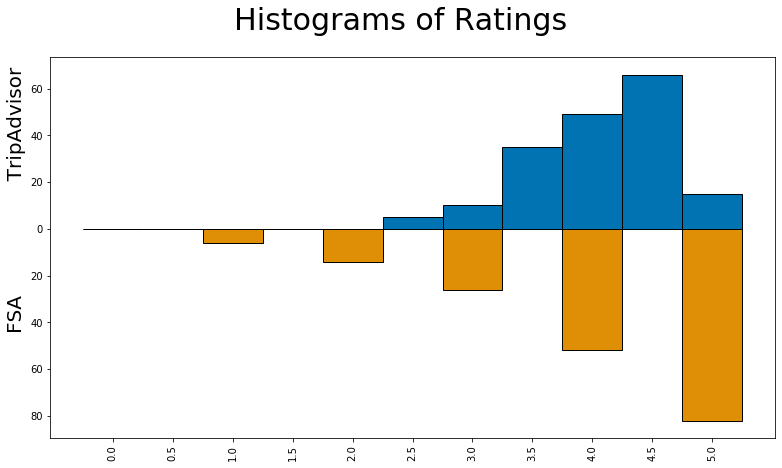

In [18]:
# reset the generator
colours=(colour for colour in sns.color_palette('colorblind').as_hex())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[13,7])
x=np.linspace(0, 5, 11)

# plot taRating as normal
ax.bar(x, df.taRating.value_counts().reindex(x, fill_value=0).values,
              edgecolor='black', width=0.5, color=colours.__next__())

# plot -fsaRating to get the reflection in the x-axis
ax.bar(x, -1*df.fsaRating.value_counts().reindex(x, fill_value=0).values,
              edgecolor='black', width=0.5, color=colours.__next__())
plt.setp(ax.get_xticklabels(), rotation='vertical')

# only want integer ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# abs the default yticks as the FSA counts aren't really negative!
ax.set_yticklabels([int(abs(count)) for count in ax.get_yticks().tolist()])

ax.set_ylabel('                FSA                  TripAdvisor ', fontsize=20)

plt.setp(ax, xticks=x)
fig.suptitle('Histograms of Ratings', fontsize=30)

Text(0.5, 0.98, 'Observed Distribution of Ratings by Business Type')

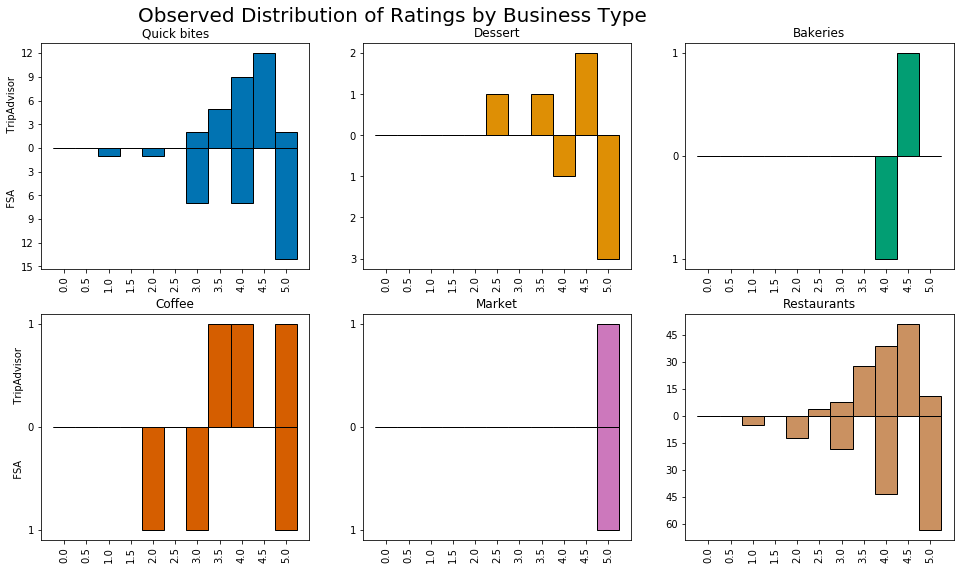

In [19]:
# reset the generator
colours=(colour for colour in sns.color_palette('colorblind').as_hex())

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[13,5])
i=0; j=0
x=np.linspace(0, 5, 11)
for type_ in set(df.Type):
    # we want full counts for each increment of 0.5 from 0 to 5, reindexing will add 0s where we need them
    colour=colours.__next__()
    axs[i][j].bar(x, df[df.Type==type_].taRating.value_counts().reindex(x, fill_value=0).values,
                  edgecolor='black', width=0.5, color=colour)
    axs[i][j].bar(x, -1*df[df.Type==type_].fsaRating.value_counts().reindex(x, fill_value=0).values,
                  edgecolor='black', width=0.5, color=colour)
    plt.setp(axs[i][j].get_xticklabels(), rotation='vertical')
    axs[i][j].yaxis.set_major_locator(MaxNLocator(integer=True))
    
    axs[i][j].set_yticklabels([int(abs(count)) for count in axs[i][j].get_yticks().tolist()])
        
    axs[i][j].title.set_text(type_.replace("_", " ").capitalize())
    
    if j==0: 
        axs[i][j].set_ylabel('          FSA                  TripAdvisor ')
    
    j += 1
    if (j == 3) & (i == 0):
        j = 0
        i = 1 

plt.setp(axs, xticks=x)
fig.subplots_adjust(right=1.1, bottom=-0.5)
fig.suptitle('Observed Distribution of Ratings by Business Type', fontsize=20)

The two above plots not only demonstrate the difference in the sampling spaces, i.e. TripAdvisor $\in \{0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5\}$ and FSA $\in \{0, 1, 2, 3, 4, 5\}$, but show the distribution of ratings is different between FSA and TripAdvisor (the former looking roughly geometric and the latter skew-normal). Let's take a closer look at the type-agnostic distributions. 

# Statistical Analyses

First let's test some different correlation measures. 

In [20]:
print("PMCC: {}, pvalue={}".format(*pearsonr(df.fsaRating, df.taRating)))
print(spearmanr(df.fsaRating, df.taRating))
print(kendalltau(df.fsaRating, df.taRating))

PMCC: -0.015007837316536706, pvalue=0.8415120469240029
SpearmanrResult(correlation=-0.05832761801687844, pvalue=0.43671182729105484)
KendalltauResult(correlation=-0.05198699231344454, pvalue=0.4096663043277593)


We compute three measures of correlation. First is Pearson (PMCC); this measure is less suited to ordinal data so the result is not particularly reliable. Spearman's Rank is designed for correlation and is the most widely used rank correlation and is suited than PMCC though can be sensitive to "ties", i.e. where values are equal and the rank is unclear. Finally we look at Kendall's tau (here it's tau-b) which is designed to be robust in the presence of ties and is defined as $$\tau = \frac{(P-Q)}{\sqrt{(P+Q+T)\times (P+Q+U)}} $$ where $P$ is the number of concordant pairs, $Q$ is the number of discordant pairs, $T$ is the number of ties in X only and $U$ is the number of ties in Y only.

We can disregard the PMCC result. Both Spearman's and Kendall's tau give similar results and provide no evidence against the null hypothesis: there is 0 correlation between FSA rating and TripAdvisor rating. This confirms what we might have suspected from the line of best fit in our earlier plot. 

Sadly our data doesn't seem particularly suited to many statistical modelling tasks, though for the purposes of illustration let's run an experiment to see if we can try and predict TripAdvisor rating based on FSA rating and location. We will use a Random Forest classifier and compare against a stratified baseline using f1 score. The f1 score will be the average across labels weighted by support, a score that suits an unbalanced dataset.

In [21]:
# define the features X...
X=df[["fsaRating", "Latitude", "Longitude"]]

# ...and the target y
y=LabelEncoder().fit_transform(df.taRating)

scores=dict()

# suppress some depreciation warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    # instantiate a calibrated RandomForestClassifier to tune hyperparameters
    calibrated_forest = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=10))
    
    # define the parameter search space, we will play around with max tree depth
    param_grid = dict(base_estimator__max_depth=[2, 4, 6, 8])
    
    # search over the parameter space
    rf = GridSearchCV(calibrated_forest, param_grid, cv=3)    
    rf.fit(X, y)
    
    # calculate the Kfold f1 scores from the fitted model
    scores['rf'] = cross_val_score(rf, scoring="f1_weighted", X=X, y=y, n_jobs=-1,
                                   cv=KFold(n_splits=4, shuffle=True, random_state=0))
    
    # a stratified baseline should better deal with imbalanced labels so we will use it as a baseline
    base = DummyClassifier(strategy="stratified")
    
    scores['base'] = cross_val_score(base, scoring="f1_weighted", X=X, y=y, n_jobs=-1,
                                     cv=KFold(n_splits=4, shuffle=True, random_state=1))

for model, score in scores.items():
    print("{} predicts with f1 score of {} (+/- {})".format(model, 
                                                            round(np.average(score), 3),
                                                            round(np.std(score), 3)))

rf predicts with f1 score of 0.284 (+/- 0.041)
base predicts with f1 score of 0.302 (+/- 0.041)


The Random Forest classifier marginally outperforms the baseline though it looks possibly insignificant: in a more detailed analysis we could easily test this assertion using the k-fold scores. The prediction accuracy improvement is not very large; this is likely a result of the lack of correlation between the two rating types. In a more detailed analysis we could look at the model components to further investigate which features were important in rating prediction. This won't be particularly interesting though given the limited model inputs and lack of predictive power so for now though let's move on.

# Geospatial Visualisation

Next let's plot the locations on a map. We will use matplotlib to overlay the coordinates on an image of a map taken from OpenStreetMaps, colouring the points by their rating. First we'll plot a quick scatter without the image to see the spread of the establishments.

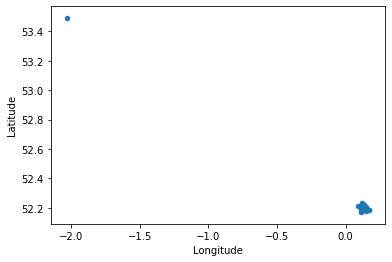

In [22]:
# quick plot of the coordinates to see how they're spread before adding an image
df.plot.scatter('Longitude', 'Latitude')

From this scatter we can see one set of coordinates is far from the rest. Let's see which this is.

In [23]:
df.iloc[df.Longitude.idxmin()]

Name         Amelie Restaurants
fsaRating                     5
taRating                      5
Latitude                53.4925
Longitude              -2.03254
Type                restaurants
Name: 1, dtype: object

A quick google search tells us this entry is erroneous. We will update the coordinates with the correct values. Once satisfied we need to create a bounding box before plotting the scatter over the image.

(0.091718, 0.173007, 52.168922, 52.232063)

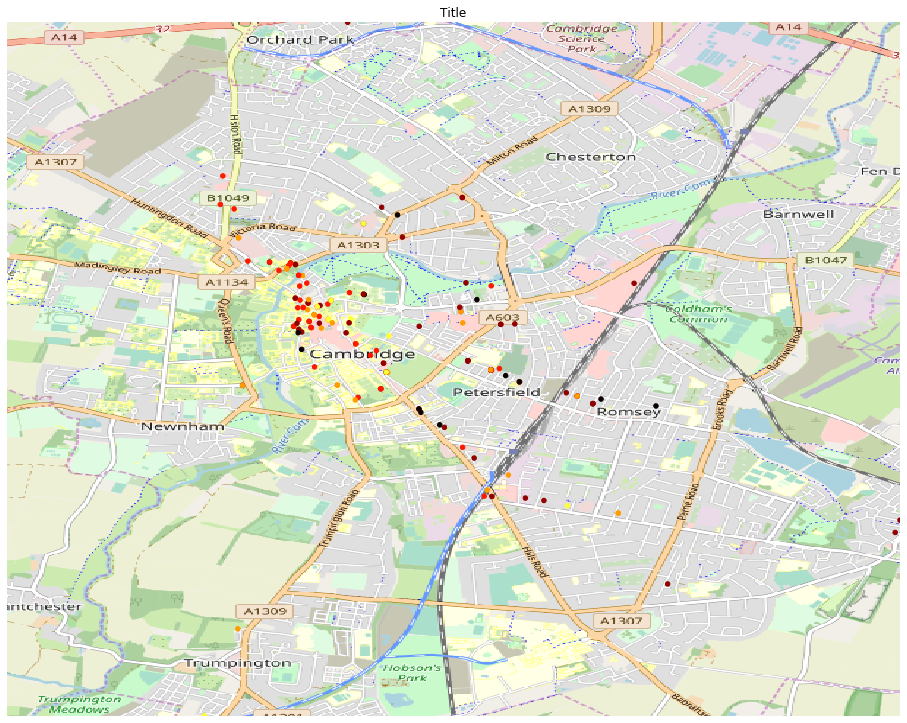

In [24]:
# from google maps: 52.2068181, 0.1344833
df.iloc[df.Longitude.idxmin(), [3, 4]] = [52.2068181, 0.1344833]

bbox = (df.Longitude.min(),   df.Longitude.max(),      
        df.Latitude.min(), df.Latitude.max())

# read in image taken from OpenStreetMaps (image resolution is not amazing!)
map1 = plt.imread('map-1.png')

fig, ax = plt.subplots(figsize = (16,14))
ax.scatter(df.Longitude, df.Latitude, zorder=1, alpha=1, 
           cmap=plt.get_cmap('hot_r'), c=df.taRating, s=20)
ax.set_title('Title')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.imshow(map1, zorder=0, extent=bbox, aspect='equal')
plt.axis('off')

This map is good as an introductory visualisation but it would be nice to be able to interact with the map to zoom in, see establishment names and more easily see the ratings. To do this we will use the folium package.

Hovering over an icon reveals the establishment name; clicking the icon will display the ratings. The icons are grouped by Tripadvisor restaurant type. It would be nice to add a legend but this requires a better knowledge of HTML. Folium also only supports Font-Awesome 4 icons (now upgraded to Font-Awesome 5) so some of the icons don't render either.

In [25]:
# instantiate a folium.Map, centred arond Cambridge 
m = folium.Map(location=[52.2, 0.12], zoom_start=13)

# create a mapping of business types to icon properties
icons = dict(restaurants=['red', 'cutlery'],
             quick_bites=['blue', 'pizza'],  # icon not supported yet :(
             dessert=['green', 'ice-cream'], # also not supported yet :(
             coffee=['lightblue', 'coffee'],
             bakeries=['pink', 'birthday-cake'],
             bars=['purple', 'cocktail'],
             market=['orange', 'shopping-basket'])

# iterate through the dataframe adding establishments to the map
for _, establishment in df.iterrows():
    folium.Marker([establishment.Latitude, establishment.Longitude], tooltip=establishment.Name,
                 popup='FSA rating: {}\nTripadvisor rating: {}'.format(establishment.fsaRating, 
                                                                       establishment.taRating),
                 icon=folium.Icon(color=icons[establishment.Type][0], prefix='fa', 
                                  icon=icons[establishment.Type][1])).add_to(m)

# display the map!
m

# Conclusion

To conclude this report let's revisit the research questions we posed in the introduction:
- Is there a relationship between the TripAdvisor and FSA ratings for a given establishment?
- Are the distributions of ratings constant across different types of establishment?

The first of these was answered by use of data visualisation methods and computation of correlation statistics. Both of the approaches suggested no clear linear relationship between the ratings and no indication of any more complex relation.

The second is less clear. From the visualisations we can easily see the distinction between the ratings distributions for FSA and TripAdvisor; by eye it's not so obvious between different establishment types for a given type of rating (i.e. quick bites vs. restaurants TripAdvisor ratings). In order to test this statistically we could employ some form of two-sampled Kolmogorov-Smirnov test, however small sample sizes might limit their effect.

We have also touched on some other interesting issues. Following on from the first question, we extended it to show that there is essentially no predictive performance from a simple Random Forest model using co-ordinates and FSA ratings as features when predicting TripAdvisor rating.

The main value in this project comes not necessarily from the statistical analyses employed or the research questions answered, but in the data acquisation and visualisations. The most useful product of this study is the final interactive map.

If this project was to be extended there are a number of things that could be looked at. More rigourous statistical analysis could be employed to comprehensively answer the research questions, the data could be expanded to consider other areas or we could even search for more data that could complement the study. 